In [1]:
import datetime
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

2022-12-19 21:44:51.140456: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Training samples

In [2]:
pairing_method = 'min-dR'
path_s = f'DNN_signal_{pairing_method}.npy'
path_b = f'DNN_background_{pairing_method}.npy'

In [3]:
X_s = np.load(path_s)
Y_s = np.eye(2)[np.array([1] * X_s.shape[0])]
X_b = np.load(path_b)
Y_b = np.eye(2)[np.array([0] * X_b.shape[0])]

X = np.vstack((X_s, X_b))
Y = np.vstack((Y_s, Y_b))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [4]:
print(f'Signal size: {X_s.shape[0]}')
print(f'Background size: {X_b.shape[0]}')

Signal size: 17217
Background size: 20355


# Training DNN

In [5]:
train_epochs = 500
patience = 10
min_delta = 0.
learning_rate = 5e-3   
batch_size = 512
save_model_name = f'DNN_best_model_{pairing_method}/'

In [6]:
# 建立 DNN
model= Sequential()
model.add(Dense(units=256, input_dim=20, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 71,682
Trainable params: 71,682
Non-trainable params: 0
_________________________________________________________________
None


2022-12-19 21:44:57.973353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 21:45:00.285181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46697 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2022-12-19 21:45:00.287229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46697 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2022-12-19 21:45:00.288446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:loc

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=train_epochs, batch_size=batch_size, callbacks=[early_stopping, check_point])

Epoch 1/500
40/47 [========================>.....] - ETA: 0s - loss: 29.4418 - accuracy: 0.5423

2022-12-19 21:45:03.129665: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 0.79904, saving model to DNN_best_model_min-dR/
INFO:tensorflow:Assets written to: DNN_best_model_min-dR/assets
47/47 [==============================] - 3s 21ms/step - loss: 25.2039 - accuracy: 0.5539 - val_loss: 0.7990 - val_accuracy: 0.6123
Epoch 2/500
40/47 [========================>.....] - ETA: 0s - loss: 0.6741 - accuracy: 0.6294
Epoch 2: val_loss improved from 0.79904 to 0.62663, saving model to DNN_best_model_min-dR/
INFO:tensorflow:Assets written to: DNN_best_model_min-dR/assets
47/47 [==============================] - 1s 17ms/step - loss: 0.6671 - accuracy: 0.6354 - val_loss: 0.6266 - val_accuracy: 0.6603
Epoch 3/500
42/47 [=========================>....] - ETA: 0s - loss: 0.6098 - accuracy: 0.6735
Epoch 3: val_loss improved from 0.62663 to 0.59881, saving model to DNN_best_model_min-dR/
INFO:tensorflow:Assets written to: DNN_best_model_min-dR/assets
47/47 [==============================] - 1s 16ms/step - loss: 0.6084 - accuracy: 0.6741

43/47 [==========================>...] - ETA: 0s - loss: 0.4571 - accuracy: 0.8005
Epoch 26: val_loss did not improve from 0.46474
47/47 [==============================] - 0s 5ms/step - loss: 0.4578 - accuracy: 0.7999 - val_loss: 0.4768 - val_accuracy: 0.7859
Epoch 27/500
37/47 [======================>.......] - ETA: 0s - loss: 0.4548 - accuracy: 0.8015
Epoch 27: val_loss did not improve from 0.46474
47/47 [==============================] - 0s 6ms/step - loss: 0.4565 - accuracy: 0.8017 - val_loss: 0.4665 - val_accuracy: 0.7936
Epoch 28/500
41/47 [=========================>....] - ETA: 0s - loss: 0.4598 - accuracy: 0.8004
Epoch 28: val_loss did not improve from 0.46474
47/47 [==============================] - 0s 6ms/step - loss: 0.4625 - accuracy: 0.7980 - val_loss: 0.4977 - val_accuracy: 0.7738
Epoch 29/500
47/47 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.7997
Epoch 29: val_loss did not improve from 0.46474
47/47 [==============================] - 0s 6ms/st

37/47 [======================>.......] - ETA: 0s - loss: 0.4130 - accuracy: 0.8184
Epoch 53: val_loss improved from 0.42239 to 0.41529, saving model to DNN_best_model_min-dR/
INFO:tensorflow:Assets written to: DNN_best_model_min-dR/assets
47/47 [==============================] - 1s 12ms/step - loss: 0.4126 - accuracy: 0.8189 - val_loss: 0.4153 - val_accuracy: 0.8120
Epoch 54/500
40/47 [========================>.....] - ETA: 0s - loss: 0.4100 - accuracy: 0.8198
Epoch 54: val_loss did not improve from 0.41529
47/47 [==============================] - 0s 6ms/step - loss: 0.4130 - accuracy: 0.8179 - val_loss: 0.4544 - val_accuracy: 0.7984
Epoch 55/500
37/47 [======================>.......] - ETA: 0s - loss: 0.4204 - accuracy: 0.8160
Epoch 55: val_loss did not improve from 0.41529
47/47 [==============================] - 0s 6ms/step - loss: 0.4166 - accuracy: 0.8185 - val_loss: 0.4199 - val_accuracy: 0.8139
Epoch 56/500
39/47 [=======================>......] - ETA: 0s - loss: 0.4021 - accura

# Accuracy and loss curve

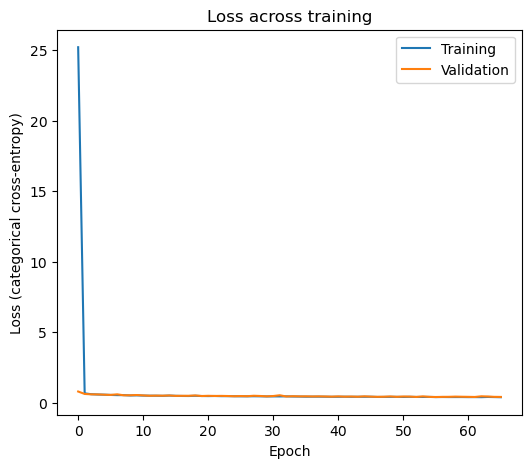

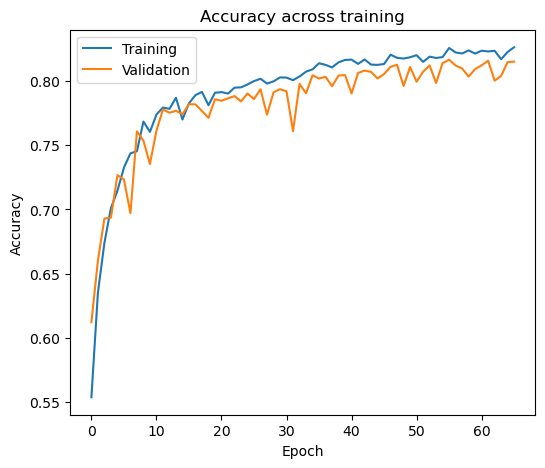

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(len(history.history['loss']))
y_train = history.history['loss']
y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (categorical cross-entropy)')
ax.legend()
plt.savefig(f'figures/loss_curve_DNN_{pairing_method}.png', facecolor='White', dpi=300, bbox_inches = 'tight')


fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(len(history.history['accuracy']))
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.savefig(f'figures/accuracy_curve_DNN_{pairing_method}.png', facecolor='White', dpi=300, bbox_inches = 'tight')

plt.show()

# Training results

In [9]:
save_model_name = f'DNN_best_model_{pairing_method}/'
loaded_model = tf.keras.models.load_model(save_model_name)

In [10]:
results = loaded_model.evaluate(x=X_test, y=y_test)
print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

235/235 [==============================] - 1s 3ms/step - loss: 0.4058 - accuracy: 0.8209
Testing Loss = 0.406, Testing Accuracy = 0.821


## Plot ROC curve

In [11]:
labels = y_test

predictions = loaded_model.predict(X_test)

235/235 [==============================] - 0s 1ms/step


In [12]:
print(labels[:10])
print(predictions[:10])

y_test = np.argmax(labels, axis=1)
y_prob = np.array(predictions)

print(y_test[:10])
print(y_prob[:10])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[[0.83592856 0.16407149]
 [0.71541137 0.28458866]
 [0.99805343 0.0019466 ]
 [0.9124232  0.08757684]
 [0.69094396 0.309056  ]
 [0.0757977  0.92420226]
 [0.45728517 0.5427149 ]
 [0.1696076  0.83039236]
 [0.9574669  0.04253304]
 [0.26861352 0.7313865 ]]
[0 0 0 0 0 1 1 1 0 1]
[[0.83592856 0.16407149]
 [0.71541137 0.28458866]
 [0.99805343 0.0019466 ]
 [0.9124232  0.08757684]
 [0.69094396 0.309056  ]
 [0.0757977  0.92420226]
 [0.45728517 0.5427149 ]
 [0.1696076  0.83039236]
 [0.9574669  0.04253304]
 [0.26861352 0.7313865 ]]


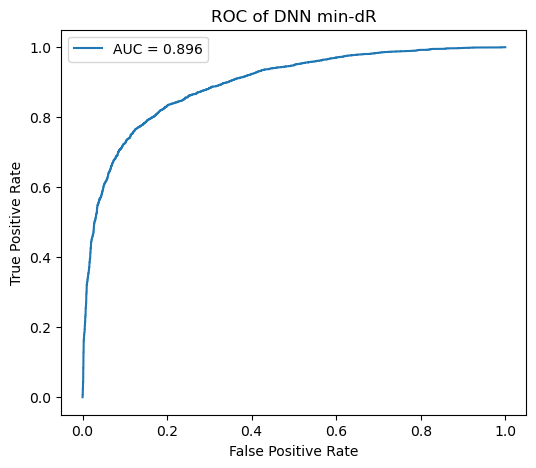

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

i=1

AUC = roc_auc_score(y_test==i,  y_prob[:,i])
fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])

ax.plot(fpr, tpr, label = f'AUC = {AUC:.3f}')

ax.set_title(f'ROC of DNN {pairing_method}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

plt.savefig(f'figures/ROC_DNN_{pairing_method}.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

# Write training results

In [31]:
now = datetime.datetime.now()

In [32]:
file_name = 'DNN_training_results.csv'

In [33]:
data_dict = {'Pairing': [pairing_method],
             'Signal': [X_s.shape[0]],
             'Background': [X_b.shape[0]],
             'ACC': [results[1]],
             'AUC': [AUC],
             'time': [now],
            }

In [34]:
df = pd.DataFrame(data_dict)
if os.path.isfile(file_name):
    training_results_df = pd.read_csv(file_name)
    pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
else:
    df.to_csv(file_name, index=False)